<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e5/Logo_%C3%A9cole_des_ponts_paristech.svg/676px-Logo_%C3%A9cole_des_ponts_paristech.svg.png" width="200"  height="200" hspace="200"/> </td>
<td> <img src="https://pbs.twimg.com/profile_images/1156541928193896448/5ihYIbCQ_200x200.png" width="200" height="200" /> </td>
</tr></table>

<br/>

<h1><center>Advanced Modelling</center></h1>



<font size="3">This session is divided into **2** parts:
- **1 - Example with computer vision: handwritten digit classifier**
- **2 - Deep Learning with tabular data: french-box-office**

In each of these parts, some **guidelines** and **hints** are given for each task. 
Do not hesitate to check the links to documentation to understand the functions you use. 
    
The goal of this session is to create a regression using deep learning. We will use an example based on computer vision and we will try to create a fully connected network for our regression problem. All the work is based on pytorch and the computer vision is taken from a tutorial done by the fastai team.
</font>

# Classification: handwritten digit recognition -- MNIST Dataset

#### Getting dataset

In [5]:
from pathlib import Path
import requests
import pickle

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [6]:
### import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


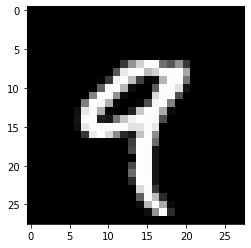

In [7]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[4].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [8]:
import torch

In [9]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [10]:
### dataset
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [11]:
### dataloader
from torch.utils.data import DataLoader

bs= 64
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(train_ds, batch_size=bs*2)

In [12]:
### model
from torch import nn

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [13]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)


In [14]:
### optimizer
from torch import optim

lr = 0.1  
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [15]:
## Loss function
import torch.nn.functional as F

loss_func = F.cross_entropy

In [16]:
### fit
import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


In [17]:
epochs= 10

In [14]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4759799555015564
1 0.28878126936912535
2 0.2655349987316132
3 0.1844113236618042
4 0.1703712854242325
5 0.159769218416214
6 0.13608565761566163
7 0.13180594417095184
8 0.13037776471853257
9 0.11728199555397034


In [15]:
model.eval()
predictions = model(x_valid)

In [16]:
(torch.argmax(predictions,dim=1)==y_valid).float().mean()

tensor(0.9629)

# Regression with Deep Learning -- French Box Office

In [18]:
import torch
torch.manual_seed(0)

#### Load data

In [19]:
import pandas as pd
import torch

def load_dataset(path):
    print(f"loading raw data..")
    data = pd.read_csv(path)
    data.drop(['title'], axis = 1, inplace = True)
    return data

def clean_data(data, drop_2020=True):
    print(f"cleaning data..")
    data = data.dropna()
    if drop_2020:
        data = data.query("year != 2020")
    data = data.sort_values(by='release_date')
    data.release_date = pd.to_datetime(data.release_date)
    data.index = data.release_date
    data = data.drop(columns = ['index', 'release_date', 'year'], errors='ignore')
    return data

def train_test_split_by_date(df: pd.DataFrame, split_date_val: str, split_date_test: str):
    """Split dataset according to a split date in format "YYYY-MM-DD"
    - train: [:split_date_1[
    - validation: [split_date_1: split_date_2[
    - test: [split_date_2:[
    """
    train = df.loc[:split_date_val].copy()
    validation = df.loc[split_date_val:split_date_test].copy()
    test = df.loc[split_date_test:].copy()
    return train, validation, test

def get_x_y(dataset):
    target = dataset.sales
    target = target.astype(float)
    features = dataset.drop(columns = ['sales'], errors='ignore')
    return features, target

In [20]:
path = '/Users/yaguethiam/Ponts/data_prepared_session4.csv'
raw_data = load_dataset(path)

data = clean_data(raw_data, drop_2020=False)
train_data, validation_data, test_data = train_test_split_by_date(data,
                                                                  '2018-01-01',
                                                                  '2020-01-01')
train_x, train_y = get_x_y(train_data)
validation_x, validation_y = get_x_y(validation_data)
test_x, test_y = get_x_y(test_data)

loading raw data..
cleaning data..


In [21]:
### create a TensorDataset for train and validation 
### Dont forget to take the log of y 
### convert the torch to float 
x_train  = torch.tensor(train_x.values).float()
x_valid  = torch.tensor(validation_x.values).float()

y_train = torch.tensor(train_y.values).log().unsqueeze(1).float()
y_valid = torch.tensor(validation_y.values).log().unsqueeze(1).float()

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [22]:
### create a Dataloader
### choose a batch size, 500 is a good choice but feel free to change it

bs = 500
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(train_ds, batch_size=bs)

In [23]:
### compute mean and std of the training data
### why do we only compute the mean and std deviation of the training data for the normalization to come?

train_mean,train_std = x_train.mean(),x_train.std()

def normalize(x, m=train_mean, s=train_std):
    '''
    Normalize a dataset x with the mean m and the std dev s
    '''
    return (x-m)/s

In [167]:
m = x_train.shape[1]

### choose a number of hidden layers
nh = 500

### choose a value for the dropout probability. 0.15 is a good choice
dropout = 0.15

## add weight decay ??


In [168]:
### build a sequential model using Lambda (defined above, use the appropriate function)
### Use also nn.Linear and nn.Dropout if you want to add regularization
### nn.ReLu if you want to build a non-linear model
### organize the layer correctly. Remember we want to normalize before anything happens
### and the output layer should be of 1 dimension as we are doing a regression

model = nn.Sequential(Lambda(normalize), nn.Linear(m,nh), nn.Dropout(dropout), nn.ReLU(),
                     nn.Linear(nh,1))

In [169]:
### Choose an optimizer which uses gradient descent
### give your optimizer the right parameters
### add momentum to it (it will help accelarate training, set it to 0.9)

from torch import optim

lr = 0.09   # learning rate
momentum = 0.9
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [170]:
### Choose a number of epochs. The goal here is a number of epoch enough for your model to train and to not overfitt
### you can try many values, the training is fast
### choose a loss function, remember what we did in the last session (it will not be the same but you can choose one that will be very similar)

epochs = 60 # how many epochs to train for
loss_func = nn.L1Loss() #loss function

In [171]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.8237561622935279
1 1.3785576535055564
2 1.530764989342294
3 1.522971267346449
4 1.2302988436687068
5 1.353371971043295
6 1.2261012428436715
7 1.2414786414277357
8 1.1865867734875764
9 1.2096693125616267
10 1.4686641955623774
11 1.3779221336967236
12 1.2265548501169974
13 1.2022442777671443
14 1.215140857045064
15 1.2294768259084317
16 1.1975795918160854
17 1.1980381019165869
18 1.1670618292948431
19 1.1734920474817865
20 1.1640494459225212
21 1.1588617761329583
22 1.1638071597842972
23 1.199037336510834
24 1.1456658025042408
25 1.15078948059511
26 1.1664474648731433
27 1.1601201537152432
28 1.2201739802141245
29 1.1521001851730757
30 1.160767086362951
31 1.1605069167104172
32 1.1371022781376552
33 1.172571165043862
34 1.1548483213269098
35 1.1399908928952789
36 1.1444840636098093
37 1.1446727285972575
38 1.169626389225284
39 1.1512216636901655
40 1.1552409347410608
41 1.1360509970637127
42 1.2040603930376328
43 1.182957324856838
44 1.184087605274696
45 1.1736622991558687
46 1.15638

In [172]:
### compute the loss function on the validation set
loss_func(model(x_valid), y_valid)

tensor(1.1275, grad_fn=<L1LossBackward>)

In [173]:
import numpy as np

In [174]:
def mean_absolute_percentage_error(y_true, y_pred):
    """in percent"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [175]:
### compute the new MAPE on the validation set

mean_absolute_percentage_error(model(x_valid).exp().detach().numpy(), y_valid.exp().detach().numpy())

112.6554012298584